#  Одноцветный пульверизатор pygame

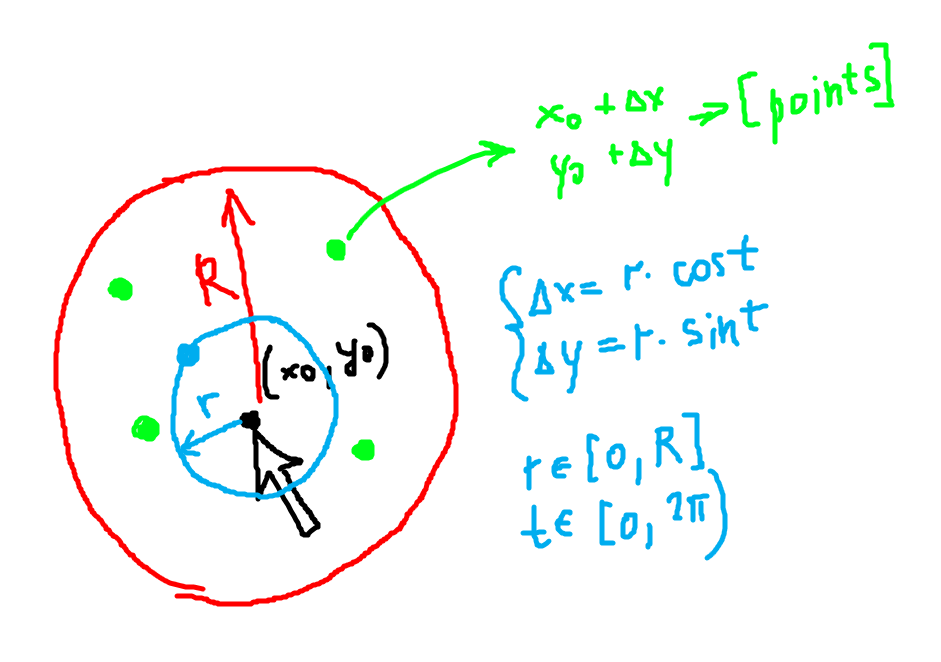

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pygame

def generate_points():
    points = np.empty((0,2), dtype='f')

    c_radius = 3
    c_color = (0,0,255)
    c_thickness = 0
    jet_radius = 30
    jet_thr = .5

    bg_color = (255,255,255)
    (width,height) = (640,480)
    screen = pygame.display.set_mode((width,height))
    pygame.display.set_caption("data generator")

    running = True
    pushing = False
    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
            elif event.type == pygame.MOUSEBUTTONDOWN:
                pushing = True
            elif event.type == pygame.MOUSEBUTTONUP:
                pushing = False

        if pushing and np.random.uniform(0,1)>jet_thr:
            (x, y) = pygame.mouse.get_pos()
            r = np.random.uniform(0,jet_radius)
            phi = np.random.uniform(0,2*np.pi)
            coord = [x+r*np.cos(phi), height-(y+r*np.sin(phi))]
            points = np.append(points, [coord], axis=0)

        screen.fill(bg_color)
        for point in points:
            pygame.draw.circle(screen,c_color,(int(point[0]),height-int(point[1])),c_radius,c_thickness)
        pygame.display.flip()

    pygame.quit()

    fig = plt.figure(figsize=(width/60,height/60))
    plt.scatter(points[:,0],points[:,1],c="blue")
    plt.show()

    return points


points = generate_points()
points

In [ ]:
np.save('points.npy', points)

In [97]:
import numpy as np

points = np.load('points.npy')
points

array([[113.96229832, 444.16848779],
       [118.16905406, 464.16477751],
       [113.34634296, 417.30684557],
       ...,
       [319.00281096, 318.41143605],
       [336.00974307, 338.29055509],
       [341.90769523, 331.08403322]])

# Реализация класса k-means 

#### Шаги алгоритма:

1. Начальный шаг: инициализация кластеров
Выбирается произвольное множество точек $\mu_i, \ i=1,...,k$, рассматриваемых как начальные центры кластеров: $\mu_i^{(0)} = \mu_i, \quad i=1,...,k$

2. Распределение векторов по кластерам

Шаг $t: \forall \mathbf{x}_i \in X, \ i=1,...,n: \mathbf{x}_i \in S_j \iff  j=\arg\min_{k}\rho(\mathbf{x}_i,\mathbf{\mu}_k^{(t-1)})^2$

3. Пересчет центров кластеров

Шаг $t: \forall i=1,...,k:  \mu_i^{(t)} = \cfrac{1}{|S_i|}\sum_{\mathbf{x}\in S_i}\mathbf{x}$

4. Проверка условия остановки:

if $\exists i\in \overline{1,k}: \mu_i^{(t)} \ne \mu_i^{(t-1)}$ then  <br>      
    &emsp;$t = t + 1$;  <br>      
    &emsp;goto 2;<br>
else<br>
    &emsp;STOP<br>

In [2]:
def get_dist_euclidean(point1, point2):
        return np.sqrt(sum([(i-j) ** 2 for i,j in zip(point1, point2)]))

def get_dist_euclidean_square(point1, point2):
        return np.sqrt(sum([(i-j) ** 2 for i,j in zip(point1, point2)]))

def get_dist_manhattan(point1, point2):
        return sum([abs(i-j) for i,j in zip(point1, point2)])

def get_dist_chebyshev(point1, point2):
        return max([abs(i-j) for i,j in zip(point1, point2)])

[[358.70713328 384.83711357]
 [592.42427406 276.76432776]
 [ 73.991772    25.44219636]]


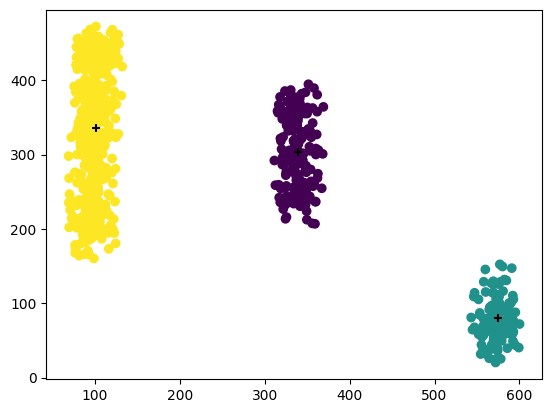

In [7]:
import matplotlib.pyplot as plt

class K_means():
    
    def __init__(self, dataset: np.ndarray, n_clusters=3, dist_type='euclidean'):
        self.dataset = dataset
        self.n_clusters = n_clusters
        self.max_n_iter = 100
        self.fitted = False
        self.labels = np.array([], dtype='i')

        xy_max = np.amax(points, axis=0)
        xy_min = np.amin(points, axis=0)

        x_delta = xy_max[0] - xy_min[0]
        y_delta = xy_max[1] - xy_min[1]

        self.tolerance = min(x_delta, y_delta) / 10000

        self.centroids = np.array([(np.random.uniform(xy_min[0], xy_max[0]), np.random.uniform(xy_min[1], xy_max[1]))
                         for _ in range(self.n_clusters)])

        match dist_type:
            case 'euclidean':
                self.get_dist = get_dist_euclidean
            case 'euclidean_square':
                self.get_dist = get_dist_euclidean_square
            case 'manhattan':
                self.get_dist = get_dist_manhattan
            case 'chebyshev':
                self.get_dist = get_dist_chebyshev
            case _:
                raise ValueError('Invalid dist_type')


    def distribute_data(self):
        self.labels = np.array([], dtype='i')
        for data in self.dataset:
            dist = np.array([self.get_dist(data,center) 
                            for center in self.centroids])
            self.labels = np.append(self.labels, dist.argmin())
            
    def recalculate_centroids(self):
        for i in range(self.n_clusters):
            num = 0
            temp = np.empty(self.dataset[0].shape)
            for k,label in enumerate(self.labels):
                if label == i:
                    temp += self.dataset[k]
                    num += 1
            self.centroids[i] = temp / num
            
    def fit(self):
        iter = 1
        while iter < self.max_n_iter:
            prev_centroids = self.centroids.copy()
            self.distribute_data()
            self.recalculate_centroids()
            if max([self.get_dist(i,j) for i,j in zip(prev_centroids,self.centroids)]) < self.tolerance:
                break
            iter += 1
        self.fitted = True

    def get_closest_centroid(self, point):
        return np.argmin(np.apply_along_axis(lambda x: self.get_dist(point, x), 1, self.centroids))

    def predict(self, points):
        if self.fitted:
            return np.apply_along_axis(self.get_closest_centroid, 1, points)
        raise ValueError('fit model before predicting')

        
        
        
        
kmeans = K_means(points)
print(kmeans.centroids)
kmeans.get_dist([1,0,1,2],[9,4,1,0])
#print(kmeans.labels)
#kmeans.distribute_data()
#print(kmeans.labels)
#kmeans.recalculate_centroids()
#print(kmeans.centroids)

kmeans.fit()

fig = plt.figure()
plt.scatter(points[:,0],points[:,1],c=kmeans.predict(points))
plt.scatter(kmeans.centroids[:,0],kmeans.centroids[:,1],c='black',marker='+')
plt.show()

## Метрики

<b>Евклидово расстояние.</b>  Геометрическое расстояние в многомерном пространстве, вычисляется следующим образом:
$$\rho(x,y) = \sqrt{\sum\limits_i (x_i - y_i)^2}$$

<b>Квадрат евклидова расстояния.</b>  Для придания большего веса более отдаленным друг от друга объектам:
$$\rho(x,y) = \sum\limits_i (x_i - y_i)^2$$
    
<b>Расстояние городских кварталов (манхэттенское расстояние).</b> Это расстояние является просто средним разностей по координатам. В большинстве случаев эта мера расстояния приводит к таким же результатам, как и для обычного расстояния Евклида. Однако отметим, что для этой меры влияние отдельных больших разностей (выбросов) уменьшается (так как они не возводятся в квадрат). Манхэттенское расстояние вычисляется по формуле:
$$\rho(x,y) = \sum\limits_i |x_i - y_i|$$
    
<b>Расстояние Чебышева.</b> Это расстояние может оказаться полезным, когда желают определить два объекта как "различные", если они различаются по какой-либо одной координате (каким-либо одним измерением). Расстояние Чебышева вычисляется по формуле:
$$\rho(x,y) = \max\limits_i |x_i - y_i|$$
    
<b>Степенное расстояние.</b> Иногда желают прогрессивно увеличить или уменьшить вес, относящийся к размерности, для которой соответствующие объекты сильно отличаются. Это может быть достигнуто с использованием степенного расстояния. Степенное расстояние вычисляется по формуле:
$$\rho(x,y) = \left( \sum\limits_i |x_i - y_i|^p \right)^{1/p}$$


## ДЗ 1. Класс kmeans

Дано:
- дан класс K_Means кластеризации данных
Требуется:
- изменить способ задания начальных положений центров кластеров: разбросать случайным образом между(!) точек заданного обучающего множества dataset (определив разброс точек по всем координатам)
- изменить способ задания параметра tolerance: значение параметра должно равняться 1/10000 от минимального диапазона изменения признаков объектов (например, если один признак изменятся в диапазоне [100,200], а другой - [0.1,10], то tolerance = (10-0.1)/10000)
- дописать метод get_dist: пользователь должен иметь возможность использовать одну из 4 метрик при подсчете расстояний между объектами (евклидово расстояние, квадрат евклидова расстояния, расстояние городских кварталов, расстояние Чебышёва)
- написать метод get_predict: методом можно воспользоваться только после обучения модели (fitted == True), метод принимает двумерный массив объектов (могут быть точки не принадлежащие исходному обучающему множеству dataset), метод возвращает одномерный массив индексов соответствующих кластеров (по близости до центров кластеров)


# Реализация класс c-means 

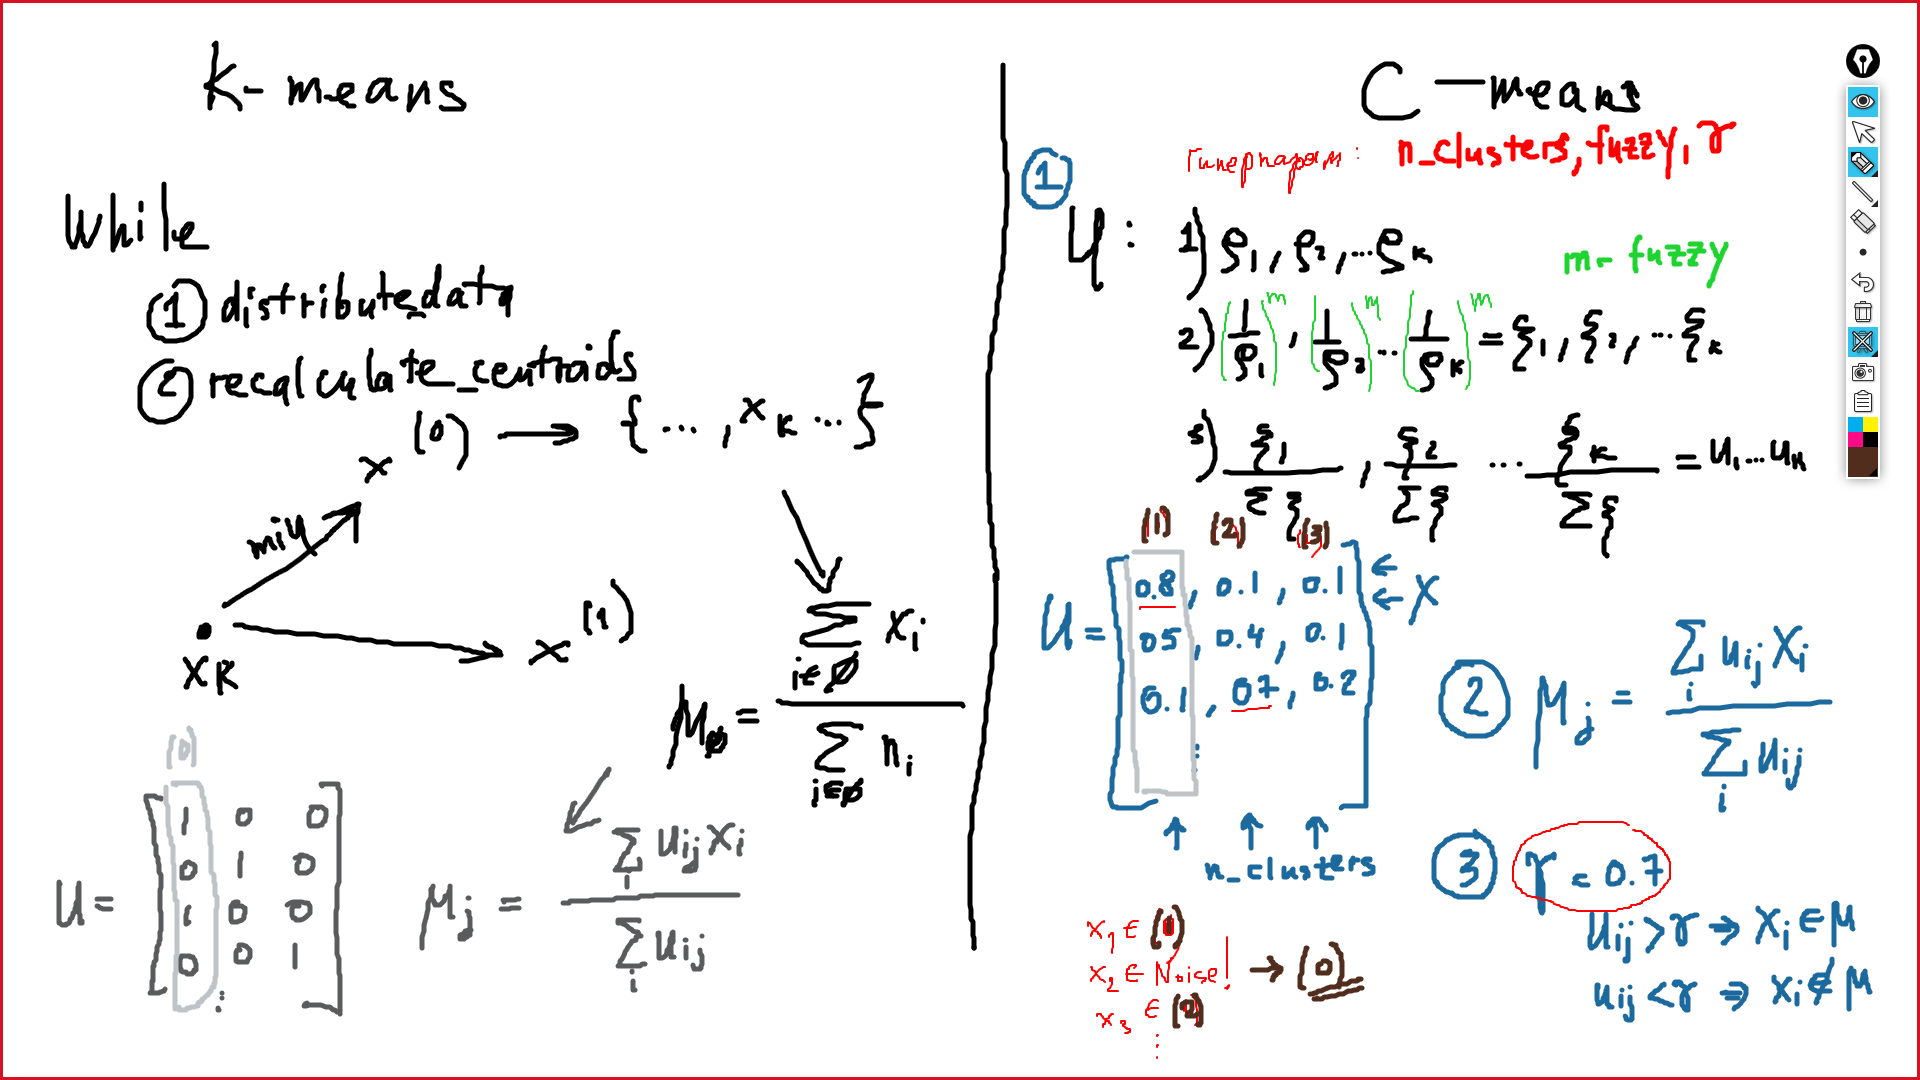

In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
def calculate_u():
    dataset = points

    n_clusters = 3
    fuzzy = 2
    cut = .8

    centroids = dataset[np.random.choice(dataset.shape[0], size=n_clusters, replace=False)] + 1
    # +1 чтобы не было нулевых расстояний, и обратных - бесконечностей
    print(centroids)

    def get_dist(list1,list2):
        return np.sqrt(sum((i-j)**2 for i,j in zip(list1,list2)))

    dist = np.array([[get_dist(i,j) for i in centroids] for j in dataset])
    print(dist.shape)
    #print(dist)

    U = (1/dist)**fuzzy
    #print(U)

    #print(U.sum(axis=1)[:,None])
    #print(U.sum(axis=1).reshape((U.shape[0],1)))
    #print(np.array([U.sum(axis=1)]).T)

    U = U/np.array([U.sum(axis=1)]).T
    print(U)
    #print(U.sum(axis=1))


calculate_u()

[[132.95141888 419.52706021]
 [348.99506303 384.8726619 ]
 [561.1495423   33.06833127]]
(806, 3)
[[0.98126371 0.01616256 0.00257373]
 [0.95886013 0.03559102 0.00554885]
 [0.99206532 0.00682545 0.00110924]
 ...
 [0.10252233 0.86465468 0.032823  ]
 [0.04589982 0.93883772 0.01526246]
 [0.05300122 0.92706339 0.01993538]]


### Алгоритм c-means состоит из следующих шагов:

1. Инициализировать матрицу $u=[u_{ij}]$, $U^{(0)}$

2. На k-шаге: вычислить центры векторов $C^{(k)} = [c_j]$ с помощью $U^{(k)}$

$$ c_j = \frac{\sum\limits_{i=1}^{N} u_{ij} x_i}{\sum\limits_{i=1}^{N} u_{ij}} $$

3. Обновить $U^{(k)}$, $U^{(k+1)}$

$$ u_{ij} = \frac{1}{\left(\frac{|| x_i - c_j ||}{\sum\limits_{k=1}^{C}|| x_i - c_k ||}\right)^m}$$

4. Если $|| U^{(k+1)} - U^{(k)} || < \epsilon$ тогда СТОП; в противном случае вернуться к шагу 2.

https://matteucci.faculty.polimi.it/Clustering/tutorial_html/cmeans.html

## ДЗ 2. Класс C_Means

Дано:
- гиперпараметр числа кластеров (n_clusters)
- гиперпараметр размытости (fuzzy)
- гиперпараметр отсечения (cut)
Требуется:
- реализовать обработку исключений, возникающих при делении на ноль 
- дописать класс C_Means:

In [98]:
## ДЗ

class C_Means():
    
    def __init__(self, dataset, n_clusters=3, fuzzy=2, cut=.9, dist_type='euclidean', max_iter=100):
        self.dataset = dataset
        self.n_clusters = n_clusters
        self.fuzzy = fuzzy
        self.cut = cut
        self.max_n_iter = max_iter
        #self.tolerance = 1e-2
        self.fitted = False
        self.labels = np.array([], dtype='i')
        #self.centroids = self.dataset[np.random.choice(self.dataset.shape[0], size=self.n_clusters, replace=False)] + 1

        xy_max = np.amax(points, axis=0)
        xy_min = np.amin(points, axis=0)

        x_delta = xy_max[0] - xy_min[0]
        y_delta = xy_max[1] - xy_min[1]

        self.tolerance = min(x_delta, y_delta) / 10000

        match dist_type:
            case 'euclidean':
                self.get_dist = get_dist_euclidean
            case 'euclidean_square':
                self.get_dist = get_dist_euclidean_square
            case 'manhattan':
                self.get_dist = get_dist_manhattan
            case 'chebyshev':
                self.get_dist = get_dist_chebyshev
            case _:
                raise ValueError('Invalid dist_type')

        self.centroids = np.array([(np.random.uniform(xy_min[0], xy_max[0]), np.random.uniform(xy_min[1], xy_max[1]))
                                        for i in range(self.n_clusters)])

        self.u = self.distribute_data()

    
    def distribute_data(self, data=None):
        if data is None:
            data = self.dataset

        dist = np.array([[self.get_dist(i,j) for i in self.centroids] for j in data])
        u = (1/dist)**self.fuzzy
        return u/np.array([u.sum(axis=1)]).T


    def recalculate_centroids(self):
        return (self.u.T @ self.dataset) / (np.sum(self.u, axis=0)[:, None])


    def centroid_or_default(self, centroids_for_point):
        max_index = np.argmax(centroids_for_point)
        if centroids_for_point[max_index] >= self.cut:
            return max_index
        return -1

        
    def get_labels(self, u=None):
        if u is None:
            u = self.u

        return np.apply_along_axis(self.centroid_or_default, 1, u)


    def fit(self):
        for i in range(self.max_n_iter):
            self.centroids = self.recalculate_centroids()
            u_new = self.distribute_data()
            self.u, u_old = u_new, self.u

            if np.all(np.abs(self.u - u_old) < self.tolerance):
                break
        self.labels = self.get_labels()


    def predict(self, points):
        predict_u = self.distribute_data(points)
        return self.get_labels(predict_u)

In [99]:
def generate_random_outliers(points, count):
    xy_max = np.amax(points, axis=0)
    xy_min = np.amin(points, axis=0)
    return np.array([(np.random.uniform(xy_min[0], xy_max[0]), np.random.uniform(xy_min[1], xy_max[1]))
                                    for i in range(count)])

points_with_outliers = np.append(points, generate_random_outliers(points, 50), axis=0)
points_with_outliers

array([[113.96229832, 444.16848779],
       [118.16905406, 464.16477751],
       [113.34634296, 417.30684557],
       ...,
       [332.97836325, 423.24355826],
       [507.16257034, 309.28097342],
       [179.70898839,  96.78299015]])

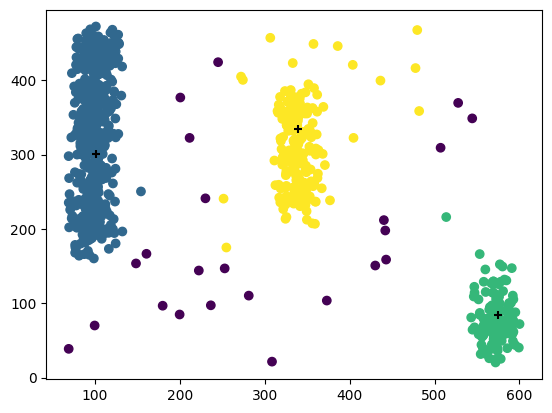

In [102]:
cmeans = C_Means(points_with_outliers,max_iter=100, cut=0.8, fuzzy=4)
cmeans.fit()
fig = plt.figure()
plt.scatter(points_with_outliers[:,0],points_with_outliers[:,1],c=cmeans.predict(points_with_outliers))
plt.scatter(kmeans.centroids[:,0],cmeans.centroids[:,1],c='black',marker='+')
plt.show()